<a href="https://colab.research.google.com/github/nayaganindia/ramesh/blob/main/StockInventoryNew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
# import the_module_that_warns

warnings.filterwarnings("ignore")

from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [41]:
# fetch the data
df_orgdata = pd.read_excel('/content/sample_data/service-data.xlsx')

In [42]:
df_orgdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28484 entries, 0 to 28483
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Invoice Date           28482 non-null  datetime64[ns]
 1   Job Card Date          28482 non-null  datetime64[ns]
 2   Business Partner Name  28484 non-null  object        
 3   Vehicle No.            28484 non-null  object        
 4   Vehicle Model          28482 non-null  object        
 5   Current KM Reading     28482 non-null  float64       
 6   INVOICE LINE TEXT      28449 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 1.5+ MB


In [43]:
# check for invalid  data
df_orgdata.isnull().sum()

Invoice Date              2
Job Card Date             2
Business Partner Name     0
Vehicle No.               0
Vehicle Model             2
Current KM Reading        2
INVOICE LINE TEXT        35
dtype: int64

In [5]:
# clean data
df_data = df_orgdata.dropna()
df_data.isnull().sum()

Invoice Date             0
Job Card Date            0
Business Partner Name    0
Vehicle No.              0
Vehicle Model            0
Current KM Reading       0
INVOICE LINE TEXT        0
dtype: int64

In [54]:
df_data.set_index(['Job Card Date'])



,Invoice Date,Business Partner Name,Vehicle No.,Vehicle Model,Current KM Reading,INVOICE LINE TEXT
Job Card Date,,,,,,
2017-05-30,2017-05-30,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000.0,ENGINE OIL
2017-05-31,2017-06-02,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758.0,ENGINE OIL
2017-05-31,2017-06-02,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758.0,POLISH
2017-05-31,2017-06-02,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758.0,CONSUMABLES
2017-05-31,2017-06-02,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758.0,COOLANT OIL
...,...,...,...,...,...,...
2019-01-06,2019-01-06,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805.0,SPROCKET RUBBER
2019-01-06,2019-01-06,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805.0,CLUTCH CABLE
2019-01-06,2019-01-06,pravXXXXXXXXXX,KA53EVXXXX,BAJAJ DISCOVER 125,12805.0,OIL FILTER


In [55]:
# we are interested only in line item and the date columns
df_job_data = df_data[['Job Card Date','INVOICE LINE TEXT']]
df_job_data.head()

,Job Card Date,INVOICE LINE TEXT
0,2017-05-30,ENGINE OIL
1,2017-05-31,ENGINE OIL
2,2017-05-31,POLISH
3,2017-05-31,CONSUMABLES
4,2017-05-31,COOLANT OIL


Job Card Date  INVOICE LINE TEXT 
2017-05-30     ENGINE OIL            1
2017-05-31     3M OIL                2
               4 WAY SWITCH          1
               AIR FILTER            1
               BORE KIT              1
                                    ..
2019-01-06     NUMBER PLATE          1
               NUMBER PLATE CLAMP    1
               OIL FILTER            1
               POLISH                2
               SPROCKET RUBBER       1
Length: 12645, dtype: int64


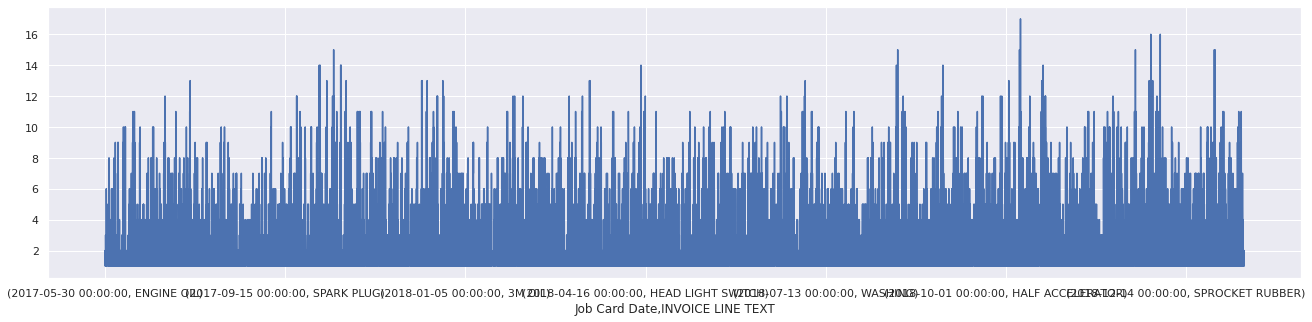

In [8]:
# We need to find the count of items for each job date 
new_data = df_data.groupby(['Job Card Date','INVOICE LINE TEXT']).size()
#new_data = df_job_data.groupby(['Job Card Date']).count()
new_data.plot(figsize=(20,5))
print(new_data)

In [29]:
# Aggregated Data in required format for forecasting
df_agg_data = pd.DataFrame({'Count' : df_data.groupby( [ 'Job Card Date','INVOICE LINE TEXT'] ).size()}).reset_index()
df_agg_data.set_index('Job Card Date')
#df_agg_data.head()
display(df_agg_data)


,Job Card Date,INVOICE LINE TEXT,Count
0,2017-05-30,ENGINE OIL,1
1,2017-05-31,3M OIL,2
2,2017-05-31,4 WAY SWITCH,1
3,2017-05-31,AIR FILTER,1
4,2017-05-31,BORE KIT,1
...,...,...,...
12640,2019-01-06,NUMBER PLATE,1
12641,2019-01-06,NUMBER PLATE CLAMP,1
12642,2019-01-06,OIL FILTER,1
12643,2019-01-06,POLISH,2


In [10]:
# Lets plot for one spare item and check the trend
df_engineoil_data = df_agg_data[df_agg_data['INVOICE LINE TEXT']== 'ENGINE OIL']
#df_engineoil_data.plot(figsize=(20,5))
display(df_engineoil_data)

,Job Card Date,INVOICE LINE TEXT,Count
0,2017-05-30,ENGINE OIL,1
13,2017-05-31,ENGINE OIL,6
43,2017-06-01,ENGINE OIL,8
63,2017-06-02,ENGINE OIL,4
79,2017-06-03,ENGINE OIL,6
...,...,...,...
12515,2019-01-02,ENGINE OIL,6
12555,2019-01-03,ENGINE OIL,6
12585,2019-01-04,ENGINE OIL,11
12613,2019-01-05,ENGINE OIL,11


In [11]:
# Let us understand the sales data distribution across the items
def itemwise_data_understanding(data):    
    df_item = data.copy()
    plt.figure(figsize=(20,10))
    sales_pivoted_df = pd.pivot_table(df_item, index='Job Card Date', 
                                      values=['Count','Job Card Date'], columns='INVOICE LINE TEXT')
    #sales_pivoted_df.plot(kind="hist",figsize=(20,10))
    # Pivoted dataframe
    display(sales_pivoted_df)
    return (df_item,sales_pivoted_df)

df_items,sales_pivoted_df = itemwise_data_understanding(df_agg_data)

Count               ...                   
INVOICE LINE TEXT 10 SIZE NUT 12 SIZE BOLT  ... handle weight tyre
Job Card Date                               ...                   
2017-05-30                NaN          NaN  ...           NaN  NaN
2017-05-31                NaN          NaN  ...           NaN  NaN
2017-06-01                NaN          NaN  ...           NaN  NaN
2017-06-02                NaN          NaN  ...           NaN  NaN
2017-06-03                NaN          NaN  ...           NaN  NaN
...                       ...          ...  ...           ...  ...
2019-01-02                NaN          NaN  ...           NaN  NaN
2019-01-03                NaN          NaN  ...           NaN  NaN
2019-01-04                NaN          NaN  ...           NaN  NaN
2019-01-05                NaN          NaN  ...           NaN  NaN
2019-01-06                NaN          NaN  ...           NaN  NaN

[553 rows x 502 columns]

<Figure size 1440x720 with 0 Axes>

Before filter: (12645, 3)
After filter: (164, 3)


,Job Card Date,INVOICE LINE TEXT,Count
0,2017-05-30,ENGINE OIL,1
13,2017-05-31,ENGINE OIL,6
43,2017-06-01,ENGINE OIL,8
63,2017-06-02,ENGINE OIL,4
79,2017-06-03,ENGINE OIL,6


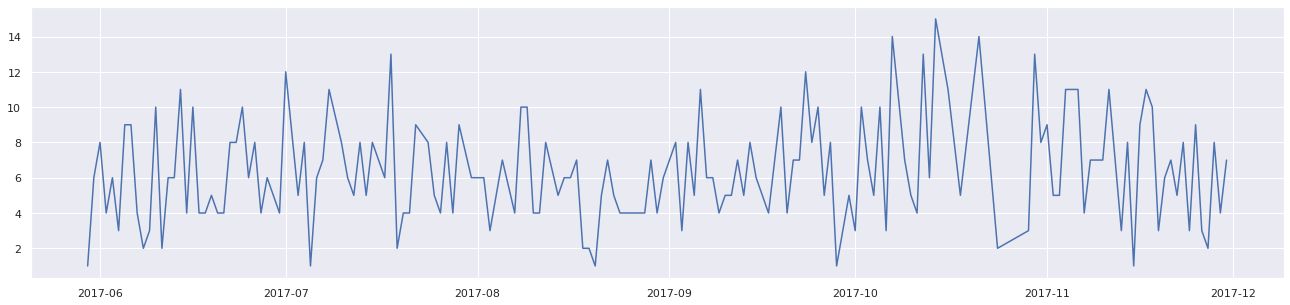

In [57]:
def Time_visualization(data):
    item_df = data.copy()
    # First, let us filterout the required data
    item = 'ENGINE OIL'   # Some Line item
    jobdate = '2017-12-01'    # Some Job Date
    print('Before filter:', item_df.shape)
    item_df = item_df[item_df['INVOICE LINE TEXT'] == item]
    item_df = item_df[item_df['Job Card Date'] < jobdate]
    print('After filter:', item_df.shape)
    display(item_df.head())

    # Let us plot this now
    #item_ts_data = [go.Scatter(x=item_df['Job Card Date'],y=item_df['Count'])]
    plt.figure(figsize=(20,5))
    plt.plot(item_df['Job Card Date'],item_df['Count'])

    plt.show()
    #py.iplot(item_ts_data,filename = 'basic-line')
    return item_df

line_item_df = Time_visualization(df_agg_data)

Before filter: (12645, 3)
After filter: (108, 3)


,Job Card Date,INVOICE LINE TEXT,Count
1,2017-05-31,3M OIL,2
32,2017-06-01,3M OIL,5
60,2017-06-02,3M OIL,4
67,2017-06-03,3M OIL,3
85,2017-06-04,3M OIL,2


            Count
count  108.000000
mean     2.870370
std      1.414825
min      1.000000
25%      2.000000
50%      3.000000
75%      4.000000
max      8.000000


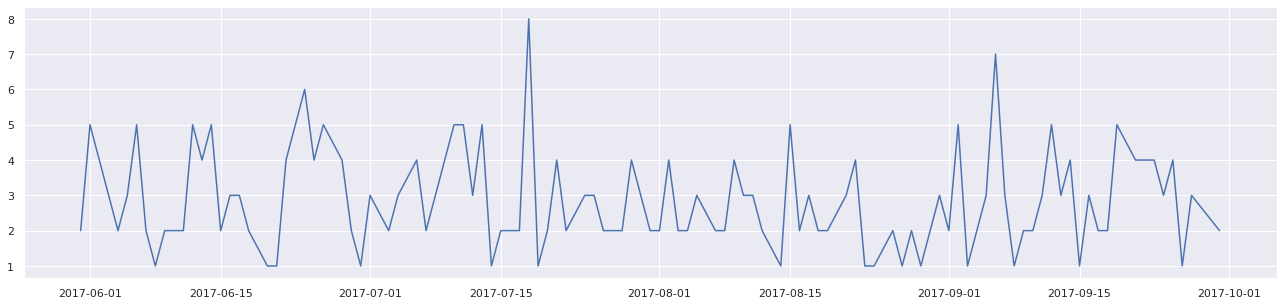

In [58]:
#play around with item and date to find a pattern
def Time_visualization2(data):
    item_df = data.copy()
    # First, let us filterout the required data
    item = '3M OIL'   # Some Line item
    jobdate = '2017-10-01'    # Some Job Date
    print('Before filter:', item_df.shape)
    item_df = item_df[item_df['INVOICE LINE TEXT'] == item]
    item_df = item_df[item_df['Job Card Date'] < jobdate]
    print('After filter:', item_df.shape)
    display(item_df.head())
    print(item_df.describe())
    # Let us plot this now
    #item_ts_data = [go.Scatter(x=item_df['Job Card Date'],y=item_df['Count'])]
    plt.figure(figsize=(20,5))
    plt.plot(item_df['Job Card Date'],item_df['Count'])

    plt.show()
    #py.iplot(item_ts_data,filename = 'basic-line')
    return item_df

line_item_df = Time_visualization2(df_agg_data)

In [59]:
# From above plots we see that there is no trend or pattern.


In [60]:
# Determining Rolling Statistics - year wise ( 12 months)
rolmean = df_engineoil_data['Count'].rolling(window=12).mean()
rolstd = df_engineoil_data['Count'].rolling(window=12).std()
#rolmean = new_data.rolling(window=12).mean()
#rolstd = new_data.rolling(window=12).std()

print('Mean :', rolmean, '\n Std :', rolstd)


Mean : 0             NaN
13            NaN
43            NaN
63            NaN
79            NaN
           ...   
12515    7.833333
12555    7.500000
12585    7.583333
12613    8.250000
12634    7.333333
Name: Count, Length: 551, dtype: float64 
 Std : 0             NaN
13            NaN
43            NaN
63            NaN
79            NaN
           ...   
12515    3.613946
12555    3.580249
12585    3.654594
12613    3.467380
12634    2.933609
Name: Count, Length: 551, dtype: float64


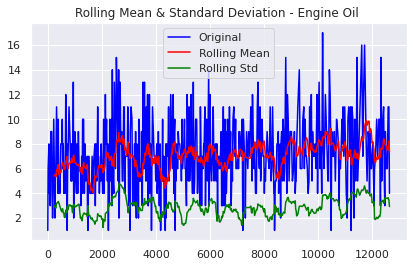

In [61]:
#Plot rolling statistics
orig = plt.plot(df_engineoil_data['Count'], color='blue',label ='Original')
#orig = plt.plot(new_data, color='blue',label ='Original')

mean = plt.plot(rolmean, color='red',label ='Rolling Mean')
std = plt.plot(rolstd, color='green',label ='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation - Engine Oil ')
plt.show(block=False)

In [62]:
# We will perform Dickey-Fuller test also to check for stationary
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(df_engineoil_data['Count'], autolag = 'AIC')
df_results = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number Of Observations Used'])

print('------- Dickey-Fuller Test Results------')

for key,value in df_test[4].items():
  df_results['Critical Value (%s)'%key]=value

print(df_results)

------- Dickey-Fuller Test Results------
Test Statistic                  -4.703389
p-value                          0.000083
#Lags Used                      14.000000
Number Of Observations Used    536.000000
Critical Value (1%)             -3.442609
Critical Value (5%)             -2.866947
Critical Value (10%)            -2.569650
dtype: float64


In [63]:
# from above plot it is obvious our Data is stationary , as 
# test statistic -> more negative
# p-value <= 0.05 (Dickey-Fuller test)


In [65]:
import fbprophet


In [90]:
# prepare the DataSet
# Prophet expects the dataset to have two columns named as ds and y. 
# ds is the date column while y is the column that we are forecasting.
df = df_agg_data[['Job Card Date','Count']]
df.rename(columns={"Job Card Date": "ds", "Count": "y"},inplace=True)
df.head()

,ds,y
0,2017-05-30,1
1,2017-05-31,2
2,2017-05-31,1
3,2017-05-31,1
4,2017-05-31,1


In [91]:
#create new object
model = fbprophet.Prophet()
# After you have instantiated a Prophet object, fit a model to your historical data. 
# by calling the fit method on the Prophet object and passing in your dataframe:
model.fit(df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# The next step is to prepare our model to make future predictions. 
# This is achieved using the Prophet.make_future_dataframe method 
# and passing the number of days we’d like to predict in the future. 

In [92]:
# Prophet has a built-in helper function make_future_dataframe to create a dataframe of future dates. 
# The make_future_dataframe function lets you specify the frequency and number of periods you would 
# like to forecast into the future. By default, the frequency is set to days. 
# Since we are using daily periodicity data in this example, we will leave freq at it’s default 
# and set the periods argument to 365, indicating that we would like to forecast 365 days into the future.

future = model.make_future_dataframe(periods=365)
future.tail()


,ds
913,2020-01-02
914,2020-01-03
915,2020-01-04
916,2020-01-05
917,2020-01-06


In [93]:
forecast = model.predict(future)

In [95]:
# If we check the head for our forecast dataframe we’ll notice that it has very many columns. 
# However, we are mainly interested in ds, yhat, yhat_lower and yhat_upper. 
# yhat is our predicted forecast, yhat_lower is the lower bound for our predictions 
# and yhat_upper is the upper bound for our predictions.

forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-05-30,2.045930,-0.508450,4.829170,2.045930,2.045930,0.128834,0.128834,0.128834,0.128834,0.128834,0.128834,0.0,0.0,0.0,2.174764
1,2017-05-31,2.046684,-0.611761,4.740165,2.046684,2.046684,-0.067667,-0.067667,-0.067667,-0.067667,-0.067667,-0.067667,0.0,0.0,0.0,1.979017
2,2017-06-01,2.047438,-0.725362,4.995107,2.047438,2.047438,-0.037117,-0.037117,-0.037117,-0.037117,-0.037117,-0.037117,0.0,0.0,0.0,2.010322
3,2017-06-02,2.048192,-0.923502,4.770013,2.048192,2.048192,-0.052540,-0.052540,-0.052540,-0.052540,-0.052540,-0.052540,0.0,0.0,0.0,1.995653
4,2017-06-03,2.048946,-0.498897,5.072782,2.048946,2.048946,0.345229,0.345229,0.345229,0.345229,0.345229,0.345229,0.0,0.0,0.0,2.394175


In [97]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
913,2020-01-02,2.998600,0.396350,5.728825
914,2020-01-03,2.984744,0.385839,5.744558
915,2020-01-04,3.384080,0.661426,6.075813
916,2020-01-05,2.765598,0.042536,5.431394
917,2020-01-06,3.000067,0.386863,5.543116


In [98]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-05-30,2.174764,-0.508450,4.829170
1,2017-05-31,1.979017,-0.611761,4.740165
2,2017-06-01,2.010322,-0.725362,4.995107
3,2017-06-02,1.995653,-0.923502,4.770013
4,2017-06-03,2.394175,-0.498897,5.072782


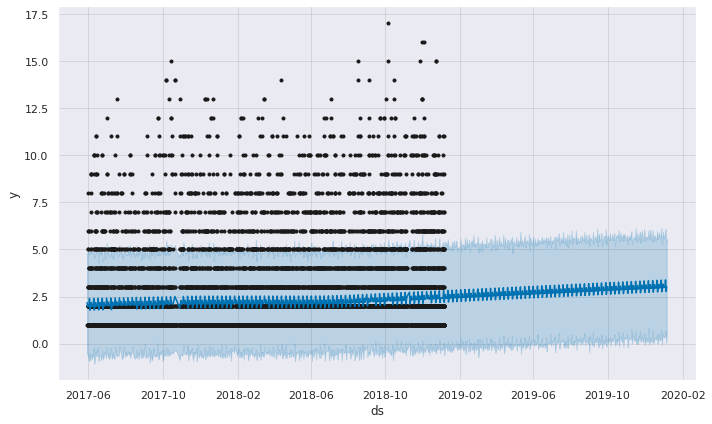

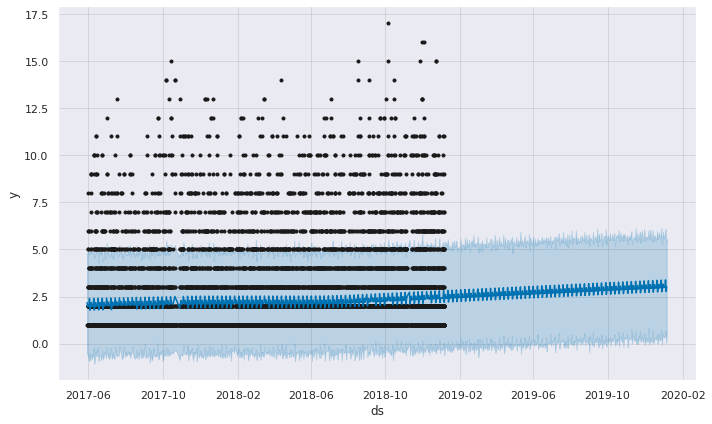

In [100]:
# Plotting the Forecasts
# The blue line in the graph represents the predicted values while the black dots represents the data in our dataset.
model.plot(forecast)


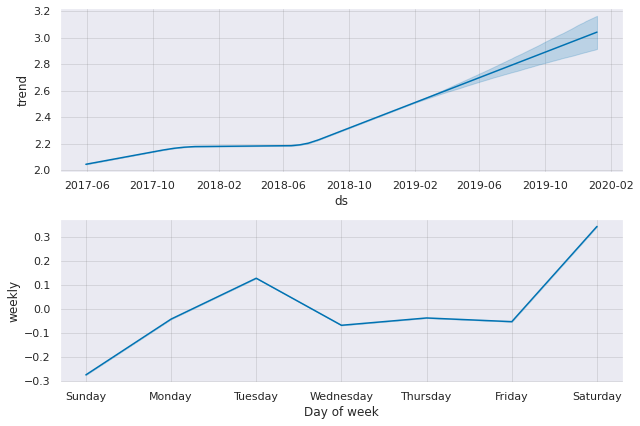

In [101]:
# visualize the individual forecast components, you can use Prophet’s built-in plot_components method
# The plot_components method plots the trend, yearly and weekly seasonality of the time series data.
model.plot_components(forecast);

In [ ]:
#Above plot shows that Prophet was able to accurately model the underlying trend in the data, 
# while also accurately modeling weekly and yearly seasonality 
#(e.g. lower order volume on weekend and holidays).



In [104]:
# Cross Validation
# Next let’s measure the forecast error using the historical data. 
# We’ll do this by comparing the predicted values with the actual values.

# In order to perform this operation we select cut of points in the history of the data 
# and fit the model with data upto that cut off point. Afterwards we compare the actual values
# to the predicted values. The cross_validation method allows us to do this in Prophet. 

#This method take the following parameters as explained below:
# - horizon the forecast horizon
# - initial the size of the initial training period
# - period the spacing between cutoff dates
#
# The output of the cross_validation method is a dataframe containing y the true values 
# and yhat the predicted values. We’ll use this dataframe to compute the prediction errors.

from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='200 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-01-06 00:00:00 and 2018-01-06 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-01-07,1.987543,-0.525060,4.498083,1,2018-01-06
1,2018-01-07,1.987543,-0.769945,4.556049,1,2018-01-06
2,2018-01-07,1.987543,-0.599146,4.658851,1,2018-01-06
3,2018-01-07,1.987543,-0.434176,4.680184,4,2018-01-06
4,2018-01-07,1.987543,-0.558232,4.745381,2,2018-01-06


In [105]:
# Obtaining the Performance Metrics
# use the performance_metrics utility to compute the Mean Squared Error(MSE), 
# Root Mean Squared Error(RMSE),Mean Absolute Error(MAE), Mean Absolute Percentage Error(MAPE) 
# and the coverage of the the yhat_lower and yhat_upper estimates.

from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,49 days,3.992875,1.998218,1.521722,0.938980,1.159453,0.886047
1,50 days,4.043888,2.010942,1.529192,0.932244,1.159453,0.881395
2,51 days,3.970024,1.992492,1.519431,0.932053,1.159453,0.884526
3,52 days,3.991112,1.997777,1.522728,0.927153,1.159453,0.885412
4,53 days,3.995726,1.998931,1.520486,0.923825,1.159453,0.885067


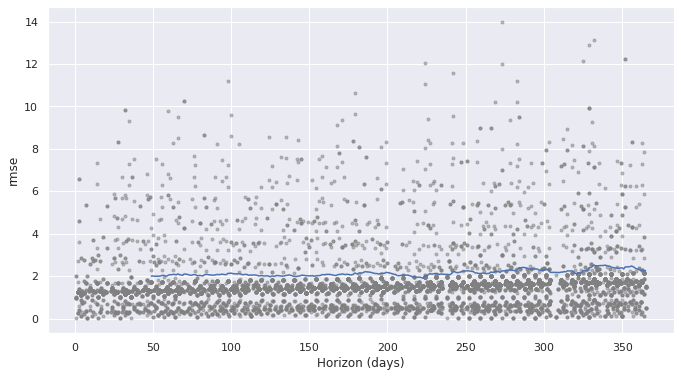

In [106]:
# Visualizing Performance Metrics
# The performance Metrics can be visualized using the plot_cross_validation_metric utility. 
# Let’s visualize the RMSE below.

from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [107]:
#Conclusion

# As we have seen Prophet is very powerful and effective in time series forecasting. 